In [1]:
import igraph as ig
import math
import pandas as pd
import random as rd
import numpy as np
import matplotlib.pyplot as plt
import datetime
import matplotlib.dates as mdates
from matplotlib.dates import DayLocator, HourLocator, DateFormatter, drange, date2num
import random
font = {'family': 'serif',
        'color':  'black',
        'weight': 'normal',
        'size': 18,
        }
params = {'legend.fontsize': 16,
          'legend.handlelength': 2.}
plt.rcParams.update(params)

import seaborn as sns
import itertools
import csv
import matplotlib.ticker as mticker

class Labeloffset():
    def __init__(self,  ax, label="", axis="y"):
        self.axis = {"y":ax.yaxis, "x":ax.xaxis}[axis]
        self.label=label
        ax.callbacks.connect(axis+'lim_changed', self.update)
        ax.figure.canvas.draw()
        self.update(None)

    def update(self, lim):
        fmt = self.axis.get_major_formatter()
        self.axis.offsetText.set_visible(False)
        self.axis.set_label_text(self.label + " "+ fmt.get_offset() )

In [2]:
df = pd.read_excel ('Data_Italy.xlsx')  # data

In [3]:
# double logistic function to calculate beta(t)
def double_smoothlog(time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2):
    result = []
    mini = 0
    maxi = time
    for x in range(time):
        if (midpoint1 > maxi | midpoint2 > maxi | midpoint1 < mini | midpoint2 < mini | midpoint1 > midpoint2):
            stop('midpoints not in range!')
        t1 = 1 / (1 + math.exp(-rate1*(x - midpoint1)))
        t2 = 1 / (1 + math.exp( rate2*(x - midpoint2)))
        out = bound1 + (bound2-bound1) * ((t1 + t2) - 1)
        result.append(out)
    return(result)


In [4]:
def simfxn(Time,popul):
    bound1 = 0.025
    bound2 = 0.001
    rate1 = 0.09
    rate2 = 0.04
    midpoint1 = 50
    midpoint2 = 126
    beta = double_smoothlog(Time, bound1 , bound2, rate1 , rate2 , midpoint1 , midpoint2)  # calculate beta(t)
    
    color_dict = {"S": "blue", "I": "red", "R": "green", "V":"orange"}
    g=ig.Graph.Erdos_Renyi(popul, m=5*popul)  # generate ER network
    pop = g.vcount()
    g.vs["state"] = "S"
    g.vs["duration"] = 0
  
    perc_vac = int(0.4*pop) # randomly select % of the population to be vaccinated. This is 0 for no vaccination scenario 
    vac_eff = 0.4  # vaccine efficacy  # This is 0 for no vaccination scenario 
    init_vac_grp = random.sample(list(range(pop)), perc_vac)  # initial vaccinated nodes prior to infection
    g.vs[init_vac_grp]["state"] = "V"

    #randomly select an infected node to start epidemic
    i = rd.randint(0, pop-1)
    if g.vs[i]["state"] != 'V':   # if initial node is not vaccinated, then set it as exposed
        g.vs[i]["state"] = "E"
    nb_S = [pop-perc_vac]
    nb_E = [1]
    nb_I = [0]
    nb_R = [0]
    nb_V = [len(init_vac_grp)]
    exposed_vac = []
    Time = Time 
    count = 0 
    for time in range(Time): #no. of days     
        for n in g.vs.select(state_eq = "E"): #iterates through each exposed node
            g.vs[n.index]["duration"] += 1 
            if g.vs[n.index]["duration"] in range(7,17):  # if exposure duration is reached, the node's state is infected I
                g.vs[n.index]["state"] = 'I'
                count = count + 1
            for nb in g.neighbors(n): #iterates through neighbours of the node n
                if g.vs[nb]["state"] == "S": #if node is susceptible conduct binomial trial
                    s=np.random.binomial(1, beta[time],1)
                    if s == 1:
                        g.vs[nb]["state"] = "E" 
                if g.vs[nb]["state"] == "V": #if node is vaccinated conduct binomial trial
                    u=np.random.binomial(1, (1-vac_eff)*beta[time],1)
                    if u == 1:
                        g.vs[nb]["state"] = "E" 
                        exposed_vac.append(nb)
                          
        for m in g.vs.select(state_eq = "I"): #iterates through each node in the network
            g.vs[m.index]["duration"] += 1 #from day 0 to infect_len this node continues to infect                                
            for nbm in g.neighbors(m): #iterates through neighbours of that node
                if g.vs[nbm]["state"] == "S": #if node is infected...

                    j=np.random.binomial(1, beta[time],1)
                    if j == 1:
                        g.vs[nbm]["state"] = "E"
            if g.vs[m.index]["duration"] in range(17,Time):
                g.vs[m.index]["state"] = 'R'
                
        nb_S.append(len(g.vs.select(state_eq = "S"))) #no. of susceptibles in population
        nb_E.append(len(g.vs.select(state_eq = "E"))) #no. of recovereds in population
        nb_I.append(len(g.vs.select(state_eq = "I"))) #no. of infecteds in population
        nb_R.append(len(g.vs.select(state_eq = "R"))) #no. of recovereds in population
        nb_V.append(len(g.vs.select(state_eq = "V"))) #no. of recovereds in population

    return(nb_S,nb_E,nb_I,nb_R,nb_V,count)



In [5]:
#
Time = 359  # time
popul = 100  # total population
rep = 50  # number of times to repeat simulation
#repeat simulation 'rep' number of times and store outcome
datavector = []
for i in range(rep):          
    simu = simfxn(Time,popul)
    datavector.append(simu)

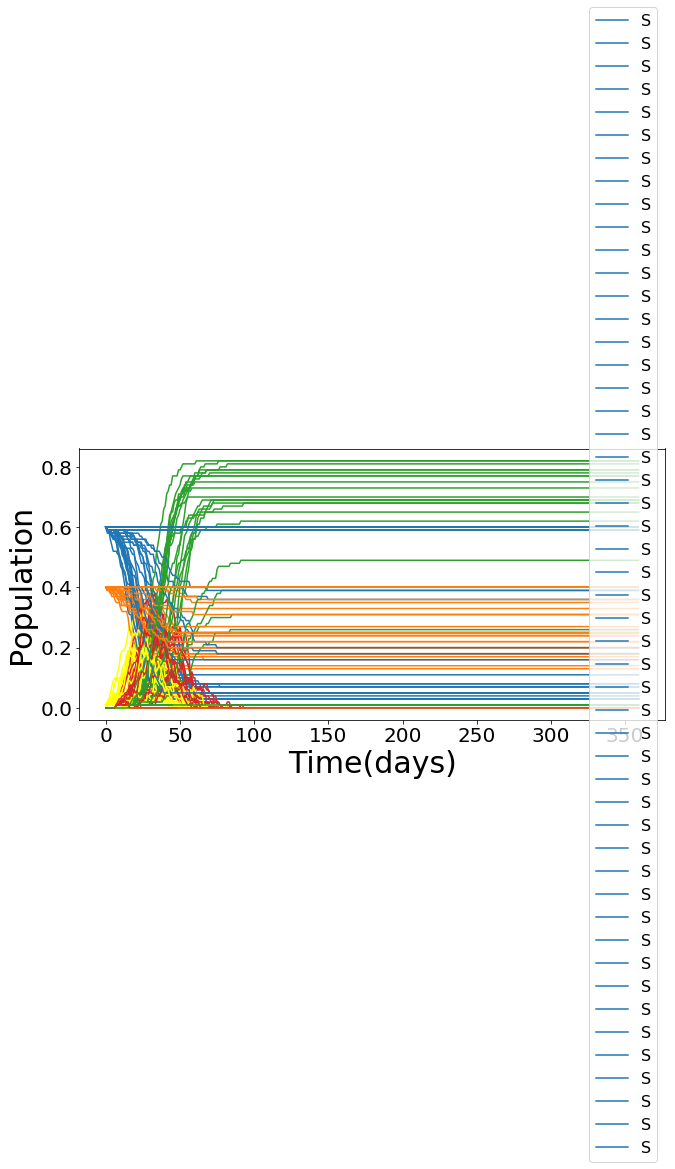

In [10]:
# plot results from simulations
plt.figure(figsize=(10.5, 5))

i_each = []

for n in datavector:
    sList = [x / popul for x in n[0]]
    eList = [x / popul for x in n[1]]
    iList = [x / popul for x in n[2]]
    rList = [x / popul for x in n[3]]
    vList = [x / popul for x in n[4]]
     
    plt.plot(sList,color = '#1f77b4')
    plt.plot(eList,color = 'yellow')
    plt.plot(iList,color = '#d62728')
    plt.plot(rList,color = '#2ca02c')
    plt.plot(vList,color = '#ff7f0e')
       
    i_each.append(iList)
     
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)
plt.ylabel('Population', fontsize=30) 
plt.xlabel('Time(days)', fontsize=30)
plt.legend(loc='right')
plt.show()

# plt.savefig('SEIRV_plot.pdf', bbox_inches='tight')



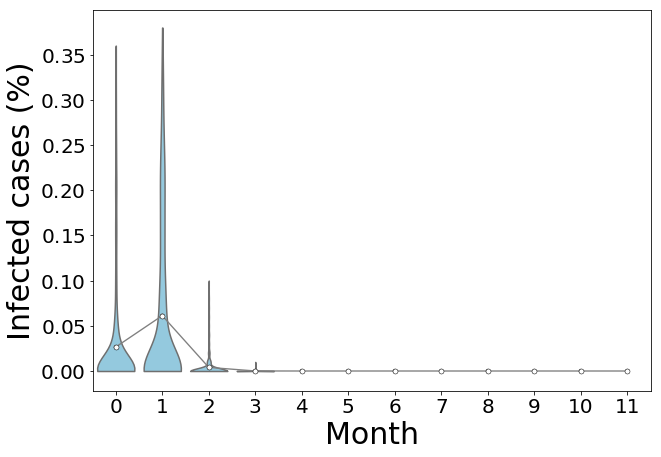

In [7]:
# VIOLIN PLOTS
#extract infection values and put in a dataframe
flat_list = [item for sublist in i_each for item in sublist]  
flat_list = []
for sublist in i_each:
    for item in sublist:
        flat_list.append(item)
        
datafr = pd.DataFrame(flat_list)

# group data into months
lst = range(0,12)
itl = list(itertools.chain.from_iterable(itertools.repeat(x, 30) for x in lst))
datafr = datafr.assign(month=itl*rep) 
datafr.columns=["inf","months"]
datafr['inf'] = pd.to_numeric(datafr['inf'], errors='coerce') # convert to numeric

#find the mean value for each month
mean = datafr.groupby(['months'])['inf'].mean().reset_index()
mean_col = datafr.groupby(['months'])['inf'].mean() # d
datafr = datafr.set_index(['months']) # 
datafr['mean_col'] = mean_col
datafr = datafr.reset_index() 
 
# plot violins
plt.figure(figsize=(10, 7))
qq = sns.violinplot(x="months", y="inf", color="skyblue",data=datafr,scale='count', bw=0.25,cut=0, inner=None)
# sns.stripplot(x="months", y="inf", data=datafr, jitter=True)
sns.swarmplot(x="months", y="inf", data=mean, color='white',edgecolor="black",linewidth=0.5, size=5)
sns.pointplot(x="months", y="inf", data=mean, color='grey',scale=0.5)
qq.set_ylabel("Infected cases (%)",fontsize=30)
qq.set_xlabel("Month",fontsize=30)
formatter = mticker.ScalarFormatter(useMathText=True)
formatter.set_powerlimits((-2,2))
qq.yaxis.set_major_formatter(formatter)
qq.yaxis.offsetText.set_fontsize(18)
plt.setp(qq.collections, alpha=1.0)
plt.tick_params(axis = 'both', which = 'major', labelsize = 20)

plt.show()

#plt.savefig('violin_plot.pdf', bbox_inches='tight')
